# Setup

In [1]:
import pyral
import pandas as pd
import numpy as np
import sabre
import matplotlib.pyplot as plt


#team = "Naos (TDS-KRK)"   
#team = "OrderSvc-KRK-TEAM2-IFS-45387011"   
#team = "Access Guardians"  
team = "Identity Management" 

current_quarter = '2021Q1'
next_quarter = '2021Q2'

iteration_weight = [12.0, 10.0, 4.0, 3.0, 1.0, 1.0]

# Establishing connection to Rally

In [2]:
rally = sabre.open_rally_connection(project=team)

# Fetching iteration data

In [3]:
response = rally.get("Iteration", query=r'((StartDate <= "today") AND (EndDate > "today"))', fetch=False)
current_iteration = [d.Name for d in response]

response = rally.get("Iteration", query=r'((StartDate >= "today-56") AND (StartDate < "today-14"))', fetch=False)
past_iterations = [d.Name for d in response]

response = rally.get("Iteration", query=r'StartDate > "today"', fetch=False)
future_iterations = [d.Name for d in response][0:6]

all_iterations = past_iterations + current_iteration + future_iterations
iterations_data = {"order" : list(range(-3,7)), "name": all_iterations }
iteration_map = {"-" : np.NaN}
for x in range(-3, 7):
    iteration_map[all_iterations[x+3]] = x
    
df_iterations = pd.DataFrame(index = range(-3,7), data = iterations_data)
df_iterations["startdate"] = df_iterations["name"].str.slice(4, 14)

df_iterations

,order,name,startdate
-3,-3,S04#2021-02-10/02-23,2021-02-10
-2,-2,S05#2021-02-24/03-09,2021-02-24
-1,-1,S06#2021-03-10/03-23,2021-03-10
0,0,S07#2021-03-24/04-06,2021-03-24
1,1,S08#2021-04-07/04-20,2021-04-07
2,2,S09#2021-04-21/05-04,2021-04-21
3,3,S10#2021-05-05/05-18,2021-05-05
4,4,S11#2021-05-19/06-01,2021-05-19
5,5,S12#2021-06-02/06-15,2021-06-02
6,6,S13#2021-06-16/06-29,2021-06-16


# Fetching Data from Rally

### Historical data

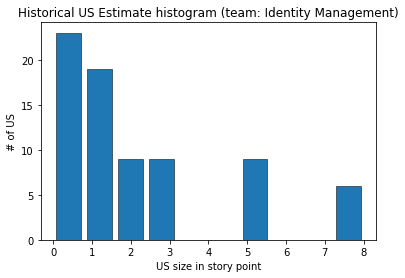

,Id,Title,State,Estimate,Iteration
0,US917564,[ESC Couchbase] Application connects to new co...,Accepted,8.0,S05#2021-02-24/03-09
1,US917570,[ESC App] obtain access to PLAB,Accepted,1.0,S05#2021-02-24/03-09
2,US917578,[ESC Couchbase] performance testing PLAB,Accepted,8.0,S06#2021-03-10/03-23
3,US982055,[MDB+dir VS+SAS] pre-REFRESH on CERT 02/19,Accepted,1.0,S04#2021-02-10/02-23
4,US982056,[MDB+dir VS+SAS] execute REFRESH on CERT on 02/19,Accepted,0.0,S04#2021-02-10/02-23
...,...,...,...,...,...
70,US1097745,[SAMs] Implementing an error handling for Tick...,Accepted,8.0,S06#2021-03-10/03-23
71,US1097798,[SSC Couchbase] Application connects to new co...,Accepted,5.0,S06#2021-03-10/03-23
72,US1097810,[SSC Couchbase] performance testing PLAB,Accepted,8.0,S06#2021-03-10/03-23
73,US1098280,03/05 [SSC] Create CR for Java update on CERT,Accepted,0.0,S05#2021-02-24/03-09


In [10]:
from_date = df_iterations.loc[-3].startdate
to_date = df_iterations.loc[0].startdate

history_query = ( f'((Iteration.StartDate >= "{from_date}") AND (Iteration.StartDate < "{to_date}"))')

response = rally.get("User Story", query=history_query, fetch=True) 
response_data = [(us.FormattedID, us.Name, us.ScheduleState, us.PlanEstimate, us.Iteration.Name if us.Iteration else "-") for us in response]
df_history = pd.DataFrame(response_data, columns=['Id', 'Title', 'State', 'Estimate', 'Iteration'])

plt.hist(df_history["Estimate"], edgecolor='#000000', linewidth=0.5, rwidth=0.8, bins=10)
plt.title(f"Historical US Estimate (team: {team})")
plt.xlabel("US size in story point")
plt.ylabel("# of US")
plt.show()

df_history

### Future data

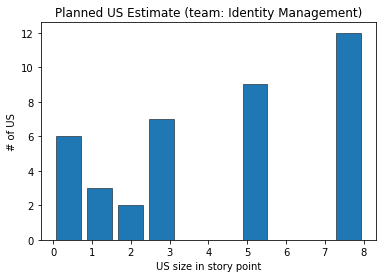

,Id,Title,State,Estimate,Iteration,Order
0,US245027,TeamCity - add validation to deploy (log check...,Idea,NaN,-,-
1,US383736,Check if Apache server is running in patching ...,Defined,3.0,-,-
2,US415286,??/?? [SSC-CB] INT - Appd Certificate updates ...,Defined,0.0,-,-
3,US415287,??/?? [SSC-CB] CERT- Appd Certificate updates...,Defined,0.0,-,-
4,US415288,??/?? [SSC-CB] PROD - Appd Certificate updates...,Defined,0.0,-,-
...,...,...,...,...,...,...
75,US1113249,Execute performance tests,Idea,NaN,S08#2021-04-07/04-20,1
76,US1113251,Perform validation on INT with ESM,Idea,NaN,S09#2021-04-21/05-04,2
77,US1113253,[SAMs] Prepare Release 5.8.0,Idea,NaN,S10#2021-05-05/05-18,3
78,US1113254,[SAMs] CERT Release 5.8.0 implementation and v...,Idea,NaN,S11#2021-05-19/06-01,4


In [11]:
from_date = df_iterations.loc[0].startdate
to_date = df_iterations.loc[6].startdate

future_query = ( '('
    + f'(((TeamFeature.Parent.ProductRoadmapQuarter = "{current_quarter}") OR (TeamFeature.Parent.ProductRoadmapQuarter = "{next_quarter}")) '
    + f'AND (TeamFeature.Parent.ProductRoadmapQuarterStatus = "Committed"))' 
    + f'AND (((Iteration.StartDate > "{from_date}") AND (Iteration.StartDate <= "{to_date}")) OR (Iteration = Null))'
    + ')' )

response = rally.get("User Story", query=future_query, fetch=True) 
response_data = [(us.FormattedID, us.Name, us.ScheduleState, us.PlanEstimate, 
                  us.Iteration.Name if us.Iteration else "-", 
                  iteration_map[us.Iteration.Name] if us.Iteration else "-") for us in response]
df_future = pd.DataFrame(response_data, columns=['Id', 'Title', 'State', 'Estimate', 'Iteration', 'Order'])
df_future_estimated = df_future[df_future["Estimate"] >= 0]

plt.hist(df_future_estimated["Estimate"], edgecolor='#000000', linewidth=0.5, rwidth=0.8, bins=10)
plt.title(f"Planned US Estimate (team: {team})")
plt.xlabel("US size in story point")
plt.ylabel("# of US")
plt.show()

df_future







# Calculating historical metrics

In [26]:
%precision 2

hist_velocities = df_history[["Iteration", "Estimate"]].groupby("Iteration").sum()
hist_throughput = df_history[["Iteration", "Id"]].groupby("Iteration").count()

metric_avg_velocity = np.mean(hist_velocities["Estimate"])
metric_avg_throughput = np.mean(hist_throughput["Id"])
metric_median_estimate = np.median(df_history["Estimate"])

d = { "name" : ["average velocity", "average throughput", "median estimate"],
      "type" : ["history", "history", "history"],
      "value" : [metric_avg_velocity, metric_avg_throughput, metric_median_estimate],
      "exptected" : ["-", "-", "-"]}

df_metrics = pd.DataFrame(data=d)
df_metrics


,name,type,value,exptected
0,average velocity,history,52.333333,-
1,average throughput,history,25.000000,-
2,median estimate,history,1.000000,-


# 
# Backlog Metrics

In [27]:
df_iter_count = df_future[["Iteration", "Id"]].groupby("Iteration").count()
df_iter_size = df_future_estimated[["Iteration", "Estimate"]].groupby("Iteration").sum()
df_iter_size["CapacityIndex"] = df_iter_size["Estimate"] / metric_avg_velocity

metric_backlog_size = df_future["Estimate"].sum()
metric_backlog_count = df_future["Id"].count()

metric_backlog_index = metric_backlog_size / metric_avg_velocity
metric_backlog_count_index = metric_backlog_count / metric_avg_throughput
metric_work_plan_index = df_iter_size.query("Iteration != '-'")["CapacityIndex"].sum()

df_small_userstories = df_future_estimated[df_future_estimated["Estimate"] <= metric_median_estimate]
metric_us_size_index = 2.0 * len(df_small_userstories) / len(df_future_estimated)

iteration_weight_map = {"-" : 0}
weight_sum = 0
for i in range(0, 6):
    iteration_weight_map[future_iterations[i]] = iteration_weight[i]
    weight_sum += iteration_weight[i]

capacity_sum = 0
for index, dt in df_iter_size.iterrows():
    capacity_sum += dt.CapacityIndex * iteration_weight_map[index]
metric_work_distribution_index = capacity_sum / weight_sum

df_metrics.loc[3] = ["backlog size", "planned", metric_backlog_size, "-"]
df_metrics.loc[4] = ["backlog count", "planned", metric_backlog_count, "-"]
df_metrics.loc[5] = ["backlog index", "planned", metric_backlog_index, "1.9 - 6.5"]
df_metrics.loc[6] = ["backlog count index", "planned", metric_backlog_count_index, "1.5 - 6.0"]
df_metrics.loc[7] = ["work plan index", "planned", metric_work_plan_index, "1.9 - 6.5"]
df_metrics.loc[8] = ["work distribution index", "planned", metric_work_distribution_index, "0.7 - 1.1"]
df_metrics.loc[9] = ["user story size index", "planned", metric_us_size_index, "> 0.6"]

df_metrics

,name,type,value,exptected
0,average velocity,history,52.333333,-
1,average throughput,history,25.000000,-
2,median estimate,history,1.000000,-
3,backlog size,planned,169.000000,-
4,backlog count,planned,80.000000,-
5,backlog index,planned,3.229299,1.9 - 6.5
6,backlog count index,planned,3.200000,1.5 - 6.0
7,work plan index,planned,0.821656,1.9 - 6.5
8,work distribution index,planned,0.318060,0.7 - 1.1
9,user story size index,planned,0.461538,> 0.6
